In [1]:
import numpy as np
import numpy.random as npr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale as scaler
from robust_loss_pytorch import distribution
import torch.nn as nn
import torch
import robust_loss_pytorch.general
from tqdm.notebook import tqdm
plt.style.use('ggplot')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
np.random.seed(1)
torch.manual_seed(1)

In [2]:
# synthetic data 1
X = np.arange(-5, 5, 0.01)
noise = npr.normal(0,1, len(X))*np.abs(np.abs(X+2)-2)/1.5
base = 1/2*X**2 + 3*np.sin(2*X)-X
Y = base + noise
Y_ = base
noise = noise

Text(0, 0.5, 'epsilon')

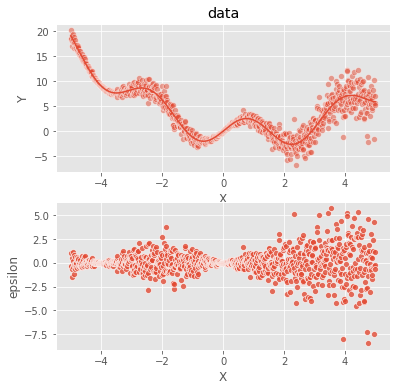

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(6,6))
sns.scatterplot(X, Y, alpha=0.5, ax=ax[0])
sns.lineplot(X, Y_, ax=ax[0])
ax[0].set_title('data')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
sns.scatterplot(X, noise, ax=ax[1], alpha=0.8)
ax[1].set_xlabel('X')
ax[1].set_ylabel('epsilon')

In [4]:
# insert outliers
def generate_data(n, rate=0.01, loc=[2,5], y=15):
    """
    n : number of data to generate
    rate : rate of outliers (set 0 if you don't want outlier)
    loc : mean location on x-axis for outliers 
    y : mean for outliers
    
    return 
    X : x-coordinate
    output : y-coordinate from noise less model
    Y : noisy output 
    """
    # base data
    X = npr.uniform(-5, 5, n)
    output = 1/2*X**2 + 3*np.sin(2*X)-X
    noise = npr.normal(0,1, len(X))*np.abs(np.abs(X+2)-2)/1.5
    Y = output+noise
    
    # generate outliers
    if not isinstance(loc, list):
        loc = [loc]
    out = int(n*rate/len(loc))
    Xout = []
    Yout = []
    for l in loc:
        out_data = npr.multivariate_normal([0,0], [[0.03,0],[0,0.5]], out)
        out_x = out_data[:, 0]+l
        out_y = out_data[:, 1]+y
        Xout.append(out_x)
        Yout.append(out_y)
    Xout = np.hstack(Xout)
    Yout = np.hstack(Yout)
    X = np.hstack([X, Xout])
    Y = np.hstack([Y, Yout])
    output = 1/2*X**2 + 3*np.sin(2*X)-X
    return X, output, Y

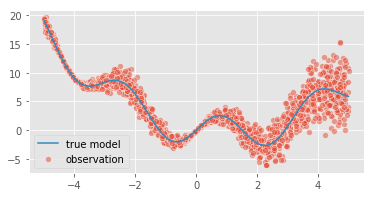

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
X, Y, Yobs = generate_data(2000, rate=0.00, loc=[-2], y=-5)
sns.scatterplot(X, Yobs, alpha=0.5, label='observation')
sns.lineplot(X, Y, color=palette[1], label='true model')

# train Alpha and C

## 2 Optimizers

In [6]:
# normalize
Yobs = scaler(Yobs)
dist = distribution.Distribution()

# TODO: random initialization?
# for example, you can use nn.Linear(1,1)
# alpha = nn.Parameter(torch.Tensor([np.exp(np.random.random([len(X)]))][0]))
alpha = nn.Parameter(torch.Tensor(np.ones([len(X)])))

# scale = nn.Parameter(torch.Tensor([np.exp(np.random.random([len(X)]))][0]))
scale = nn.Parameter(torch.Tensor(np.ones([len(X)])))

In [7]:
# try optimizing alternatively?
opt1 = torch.optim.Adam([alpha], lr = 1e-4) 
opt2 = torch.optim.Adam([scale], lr = 1e-4) 
x = torch.Tensor(X)
y = torch.Tensor(Yobs)

In [8]:
# train 
for epoch in tqdm(range(15000)):     
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y - x, alpha=torch.exp(alpha), scale=torch.exp(scale)))
    loss = loss + scale.mean() + dist.log_base_partition_function(torch.exp(alpha)).mean()
    
    if epoch % 2 ==0:
        opt1.zero_grad() 
        loss.backward() 
        opt1.step() 
    else:
        opt2.zero_grad() 
        loss.backward() 
        opt2.step() 
        
    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  

0   : loss=2.977804
1000: loss=2.836968
2000: loss=2.730299
3000: loss=2.646226
4000: loss=2.577803
5000: loss=2.520375
6000: loss=2.469747
7000: loss=2.416906
8000: loss=2.390105
9000: loss=2.369415
10000: loss=2.351266
11000: loss=2.334980
12000: loss=2.320341
13000: loss=2.307059
14000: loss=2.294730



Text(0.5, 0, 'X')

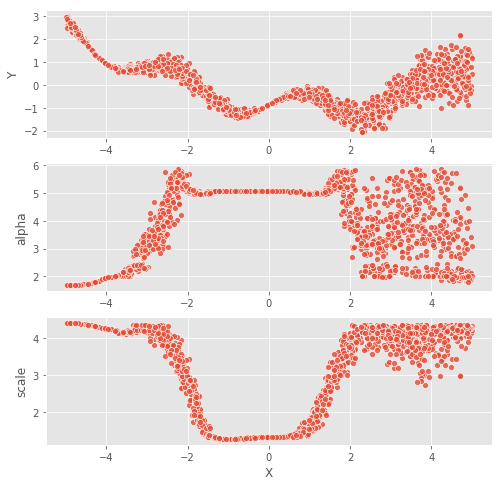

In [9]:
# plot result
alpha_np = torch.exp(alpha).data.numpy()
scale_np = torch.exp(scale).data.numpy()

fig, ax = plt.subplots(3, 1, figsize=(8,8))
sns.scatterplot(X, Yobs, ax=ax[0], alpha=0.8)
sns.scatterplot(X, alpha_np, ax=ax[1], alpha=0.8)
sns.scatterplot(X, scale_np, ax=ax[2], alpha=0.8)
ax[0].set_ylabel('Y')
ax[1].set_ylabel('alpha')
ax[2].set_ylabel('scale')
ax[2].set_xlabel('X')

In [10]:
# # remove all points where alpha > 2
# fig, ax = plt.subplots(3, 1, figsize=(8,8))
# sns.scatterplot(X[alpha_np<2], Yobs[alpha_np<2], ax=ax[0], alpha=0.8)
# sns.scatterplot(X[alpha_np>2], Yobs[alpha_np>2], ax=ax[0], alpha=0.8)
# sns.scatterplot(X[alpha_np<2], alpha_np[alpha_np<2], ax=ax[1], alpha=0.8)
# sns.scatterplot(X[alpha_np<2], scale_np[alpha_np<2], ax=ax[2], alpha=0.8)
# ax[0].set_ylabel('Y')
# ax[1].set_ylabel('alpha')
# ax[2].set_ylabel('scale')
# ax[2].set_xlabel('X')

## 1 Optimizer

In [11]:
# TODO: random initialization?
# for example, you can use nn.Linear(1,1)
alpha = nn.Parameter(torch.Tensor([np.exp(np.random.random([len(X)]))][0]))
alpha = nn.Parameter(torch.Tensor(np.ones([len(X)])))

scale = nn.Parameter(torch.Tensor([np.exp(np.random.random([len(X)]))][0]))
scale = nn.Parameter(torch.Tensor(np.ones([len(X)])))

In [12]:
# try optimizing alternatively?
opt = torch.optim.Adam([alpha, scale], lr = 1e-4) 

In [13]:
# train 
for epoch in tqdm(range(15000)):     
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y - x, alpha=torch.exp(alpha), scale=torch.exp(scale)))
    loss  = loss + scale.mean() + dist.log_base_partition_function(torch.exp(alpha)).mean()
    opt.zero_grad() 
    loss.backward() 
    opt.step() 

    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  

0   : loss=2.977804
1000: loss=2.730299
2000: loss=2.577803
3000: loss=2.469746
4000: loss=2.390102
5000: loss=2.351266
6000: loss=2.320343
7000: loss=2.294737
8000: loss=2.272445
9000: loss=2.253683
10000: loss=2.238284
11000: loss=2.225594
12000: loss=2.214948
13000: loss=2.205889
14000: loss=2.197899



Text(0.5, 0, 'X')

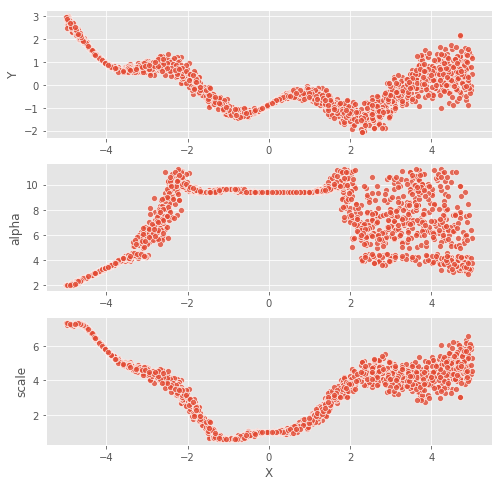

In [14]:
# plot result
alpha_np = torch.exp(alpha).data.numpy()
scale_np = torch.exp(scale).data.numpy()

fig, ax = plt.subplots(3, 1, figsize=(8,8))
sns.scatterplot(X, Yobs, ax=ax[0], alpha=0.8)
sns.scatterplot(X, alpha_np, ax=ax[1], alpha=0.8)
sns.scatterplot(X, scale_np, ax=ax[2], alpha=0.8)
ax[0].set_ylabel('Y')
ax[1].set_ylabel('alpha')
ax[2].set_ylabel('scale')
ax[2].set_xlabel('X')

In [15]:
# # remove all points where alpha > 2
# fig, ax = plt.subplots(3, 1, figsize=(8,8))
# sns.scatterplot(X[alpha_np<2], Yobs[alpha_np<2], ax=ax[0], alpha=0.8)
# sns.scatterplot(X[alpha_np>2], Yobs[alpha_np>2], ax=ax[0], alpha=0.8)

# sns.scatterplot(X[alpha_np<2], alpha_np[alpha_np<2], ax=ax[1], alpha=0.8)
# sns.scatterplot(X[alpha_np<2], scale_np[alpha_np<2], ax=ax[2], alpha=0.8)
# ax[0].set_ylabel('Y')
# ax[1].set_ylabel('alpha')
# ax[2].set_ylabel('scale')
# ax[2].set_xlabel('X')

## train 1 alpha, N c

In [16]:
# TODO: random initialization?
# for example, you can use nn.Linear(1,1)
alpha = nn.Parameter(torch.Tensor([np.exp(np.random.random([1]))][0]))
alpha = nn.Parameter(torch.Tensor(np.ones([1])))

scale = nn.Parameter(torch.Tensor([np.exp(np.random.random([len(X)][0]))]))
scale = nn.Parameter(torch.Tensor(np.ones([len(X)])))

In [17]:
# try optimizing alternatively?
opt = torch.optim.Adam([alpha, scale], lr = 1e-4) 

In [18]:
# train 
for epoch in tqdm(range(15000)):     
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y - x, alpha=torch.exp(alpha), scale=torch.exp(scale)))
    loss  = loss + scale.mean() + dist.log_base_partition_function(torch.exp(alpha)).mean()
    opt.zero_grad() 
    loss.backward() 
    opt.step() 

    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  

0   : loss=2.977804
1000: loss=2.743499
2000: loss=2.607673
3000: loss=2.523923
4000: loss=2.470003
5000: loss=2.425277
6000: loss=2.378797
7000: loss=2.335015
8000: loss=2.298508
9000: loss=2.269759
10000: loss=2.247628
11000: loss=2.230719
12000: loss=2.217665
13000: loss=2.207279
14000: loss=2.198763



Text(0.5, 0, 'X')

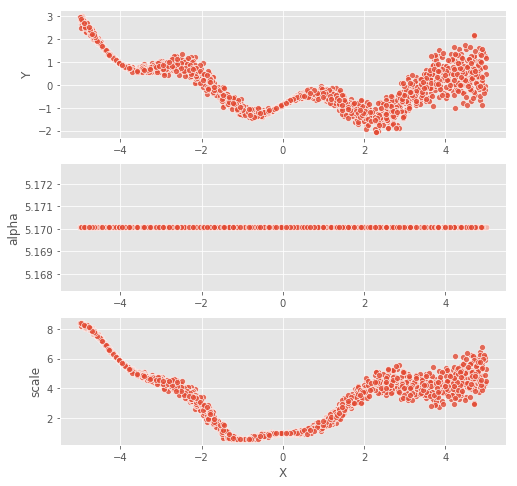

In [19]:
# plot result
alpha_np = np.repeat(torch.exp(alpha).data.numpy(), len(X))
scale_np = torch.exp(scale).data.numpy()

fig, ax = plt.subplots(3, 1, figsize=(8,8))
sns.scatterplot(X, Yobs, ax=ax[0], alpha=0.8)
sns.scatterplot(X, alpha_np, ax=ax[1], alpha=0.8)
sns.scatterplot(X, scale_np, ax=ax[2], alpha=0.8)

ax[0].set_ylabel('Y')
ax[1].set_ylabel('alpha')
ax[2].set_ylabel('scale')
ax[2].set_xlabel('X')

## train N alpha 1 c

In [20]:
# TODO: random initialization?
# for example, you can use nn.Linear(1,1)
alpha = nn.Parameter(torch.Tensor([np.exp(np.random.random([len(X)]))][0]))
alpha = nn.Parameter(torch.Tensor(np.ones([len(X)])))

scale = nn.Parameter(torch.Tensor([np.exp(np.random.random([1]))][0]))
scale = nn.Parameter(torch.Tensor(np.ones([1])))

In [21]:
# try optimizing alternatively?
opt = torch.optim.Adam([alpha, scale], lr = 1e-4) 

In [22]:
# train 
for epoch in tqdm(range(15000)):     
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y - x, alpha=torch.exp(alpha), scale=torch.exp(scale)))
    loss  = loss + scale.mean() + dist.log_base_partition_function(torch.exp(alpha)).mean()

    opt.zero_grad() 
    loss.backward() 
    opt.step() 

    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  

0   : loss=2.977804
1000: loss=2.782555
2000: loss=2.677925
3000: loss=2.610087
4000: loss=2.563289
5000: loss=2.553518
6000: loss=2.547205
7000: loss=2.542295
8000: loss=2.538296
9000: loss=2.535003
10000: loss=2.532274
11000: loss=2.530030
12000: loss=2.528163
13000: loss=2.526609
14000: loss=2.525325



Text(0.5, 0, 'X')

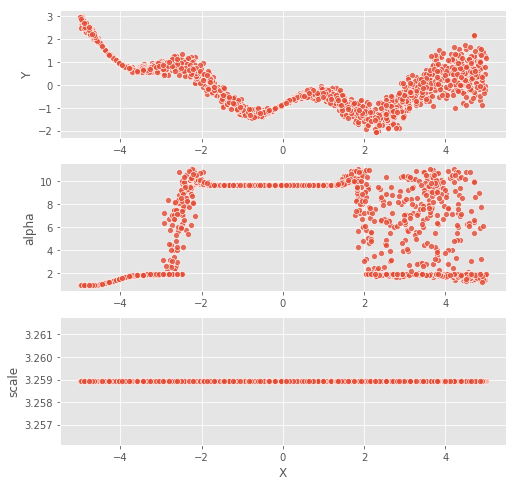

In [23]:
# plot result
alpha_np = torch.exp(alpha).data.numpy()
scale_np = np.repeat(torch.exp(scale).data.numpy(), len(X))

fig, ax = plt.subplots(3, 1, figsize=(8,8))
sns.scatterplot(X, Yobs, ax=ax[0], alpha=0.8)
sns.scatterplot(X, alpha_np, ax=ax[1], alpha=0.8)
sns.scatterplot(X, scale_np, ax=ax[2], alpha=0.8)

ax[0].set_ylabel('Y')
ax[1].set_ylabel('alpha')
ax[2].set_ylabel('scale')
ax[2].set_xlabel('X')

In [24]:
# fig, ax = plt.subplots(3, 1, figsize=(8,8))
# sns.scatterplot(X[alpha_np<2], Yobs[alpha_np<2], ax=ax[0], alpha=0.8)
# sns.scatterplot(X[alpha_np>2], Yobs[alpha_np>2], ax=ax[0], alpha=0.8)
# sns.scatterplot(X[alpha_np<2], alpha_np[alpha_np<2], ax=ax[1], alpha=0.8)
# sns.scatterplot(X[alpha_np<2], scale_np[alpha_np<2], ax=ax[2], alpha=0.8)

# ax[0].set_ylabel('Y')
# ax[1].set_ylabel('alpha')
# ax[2].set_ylabel('scale')
# ax[2].set_xlabel('X')